In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, f1_score, fbeta_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, roc_curve
from datetime import date
import time

import numpy as np
from statistics import mean
from sklearn.impute import KNNImputer
from sklearn import preprocessing

import matplotlib.pyplot as plt

from pyAgrum.lib.bn2roc import showROC_PR, getROCpoints

In [2]:
from IPython.display import IFrame

In [3]:
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
import lightgbm

In [4]:
from matplotlib import pylab
import ipywidgets


In [5]:
import pyAgrum as gum

In [6]:
import pyAgrum.skbn as skbn
import pyAgrum.lib.notebook as gnb
import pyAgrum.lib.explain as exp

In [7]:
df = pd.read_csv('df_pretreat.csv')

In [8]:
df

,mont_remb_init,nb_avr_typ_a,nb_avr_typ_b,nb_avr_typ_c,nb_avr_typ_d,sum_mont_avr,nb_pa_rjt,typ_avr_decl,is_cod_comp_1,is_cod_comp_2,...,max_flg_pro_cds,flg_coll,sum_mmf3_cds,nb_repri,anc_dernier_repri,nb_cibl_enrichi,anc_dernier_cibl_enrichi,nb_enrichi_refus,anc_dernier_refus_enrichi,cible
0,290,0,0,1,0,-290,0,A,0,0,...,0,0,0,0,1,0,1,0,1,0
1,100-114,1,0,0,0,"-204,-132",2_plus,B,0,0,...,0,0,0,0,1,0,1,0,1,0
2,100-114,0,0,1,0,"-132,0",0,A,0,0,...,0,0,0,0,1,0,1,0,1,0
3,220-344,1,0,0,0,"-382,-289",0,B,0,0,...,0,0,1,0,1,1,1,1,1,1
4,220-344,2_plus,0,0,0,"-289,-204",0,B,0,0,...,0,0,0,0,1,0,1,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26736,220-344,1,0,0,0,"-289,-204",0,B,0,0,...,0,0,1,0,1,1,1,0,1,1
26737,250,0,0,2_plus,0,"-289,-204",0,A,0,0,...,0,0,0,0,1,0,1,0,1,0
26738,250,0,0,1,0,-250,0,A,0,0,...,0,0,0,0,1,0,1,0,1,0
26739,344-3300,0,0,1,0,"-3562,-382",0,A,0,0,...,0,0,0,0,1,0,1,0,1,0


In [9]:
for col in df.describe(include='object').columns:
    df[col] = df[col].astype('str') 

# Apprentissage

In [10]:
seuil_rappel = 0.90

def score_perso(y_valid, y_pred):
    
    total = y_valid.sum()
    
    def recall_for(x):
        found = ((y_pred > x) & (y_valid == 1)).sum()
        return float(found) / total
    
    x = 0.995
    while recall_for(x) < seuil_rappel and x > 0.005:
        x -= 0.005
        
    return (y_pred > x).sum() / float(len(y_valid))

In [11]:
def apprentissage(df, learningMethod, beta=1, usePR=True, courbes=True) :
    X_train, X_test, Y_train, Y_test = train_test_split(df.drop('cible', axis=1), df['cible'],
                                                        shuffle=True, test_size=0.25)

    df_train = pd.concat([X_train, Y_train], axis=1)
    
    cl = skbn.BNClassifier(learningMethod=learningMethod, usePR=usePR,beta=beta,
                           discretizationThreshold=33)
    cl.fit(X_train, Y_train)
    gum.lib.bn2roc.showROC_PR(cl.bn,df_train,'cible', 1, beta=beta, show_progress=True,
                              show_fig=True, save_fig=True, with_labels=True)
    y_test_pred = cl.predict(X_test)

    print("Results on test set :")
    print(f"F-score : {f1_score(Y_test, y_test_pred):.2f}")
    print(f"F2-score : {fbeta_score(Y_test, y_test_pred, beta=2):.2f}")
    print(f"Precision : {precision_recall_fscore_support(Y_test, y_test_pred)[0][1]:.2f}")
    print(f"Recall : {precision_recall_fscore_support(Y_test, y_test_pred)[1][1]:.2f}")
    print(f"Accuracy : {accuracy_score(Y_test, y_test_pred):.2f}")

    print("Confusion Matrix")
    print(confusion_matrix(Y_test, y_test_pred))
    
    print(f"Score Perso : {score_perso(Y_test, y_test_pred):.2f}")

    return cl

## Greedy Hill Climbing

dataframe: 100%|███████████████████████████████████████████████████████████████|


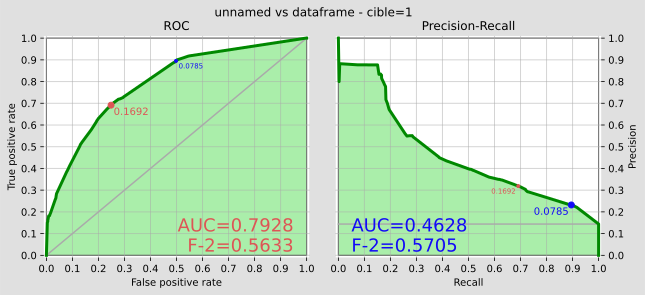

Results on test set :
F-score : 0.35
F2-score : 0.55
Precision : 0.22
Recall : 0.87
Accuracy : 0.55
Confusion Matrix
[[2845 2888]
 [ 126  827]]
Score Perso : 0.56


In [12]:
cl_GHC = apprentissage(df, learningMethod='GHC', beta=2)

In [13]:
cl_GHC.MarkovBlanket

(pyAgrum.BayesNet<double>@0x106c69e00) BN{nodes: 6, arcs: 6, domainSize: 324, dim: 49, mem: 664o}

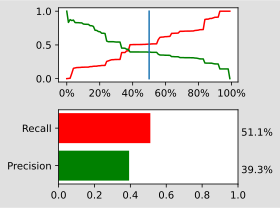

interactive(children=(IntSlider(value=50, description='rate'), Output(layout=Layout(height='250px'))), _dom_cl…

In [14]:
gum.lib.bn2roc.animPR(cl_GHC.bn, df, target="cible", label="1")

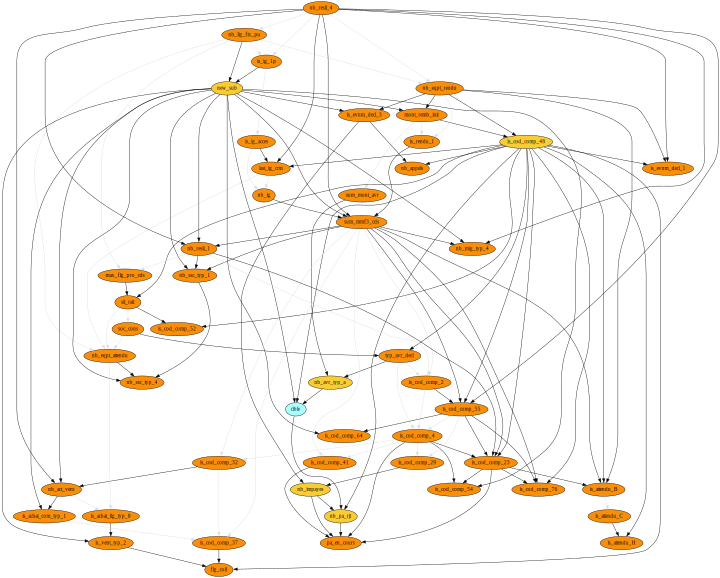

In [16]:
gnb.showGraph(exp.nestedMarkovBlankets(cl_GHC.bn, 'cible',2), size='10!')

In [17]:
len(exp.nestedMarkovBlanketsNames(cl_GHC.bn, 'cible',2))

50

## MIIC

In [18]:
#cl_MIIC = apprentissage(df, learningMethod='MIIC', beta=2)

In [19]:
X_train, X_test, Y_train, Y_test = train_test_split(df.drop('cible', axis=1), df['cible'],
                                                    shuffle=True, test_size=0.25)
df_train = pd.concat([X_train, Y_train], axis=1)
df_test = pd.concat([X_test, Y_test], axis=1)

In [20]:
bn_miic = gum.loadBN('bn_miic.bifxml')

dataframe: 100%|███████████████████████████████████████████████████████████████|


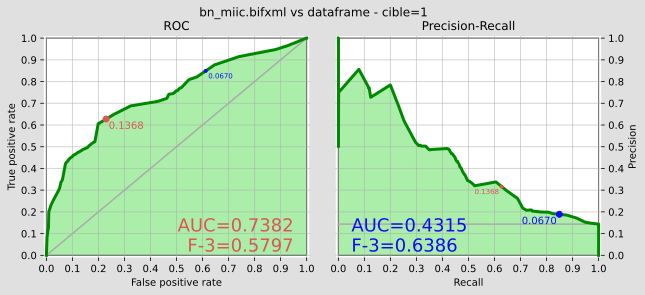

In [21]:
gum.lib.bn2roc.showROC_PR(bn_miic, df_train,'cible', 1, beta=3, show_progress=True,
                          show_fig=True, save_fig=True, with_labels=True)

In [22]:
cl_MIIC = skbn.BNClassifier()


In [23]:
cl_MIIC.fromTrainedModel(bn = bn_miic, targetAttribute = 'cible', targetModality = '1',
                             threshold = 0.067)

In [24]:
cl_MIIC.MarkovBlanket

(pyAgrum.BayesNet<double>@0x1058a0600) BN{nodes: 10, arcs: 11, domainSize: 12960, dim: 169, mem: 2Ko 40o}

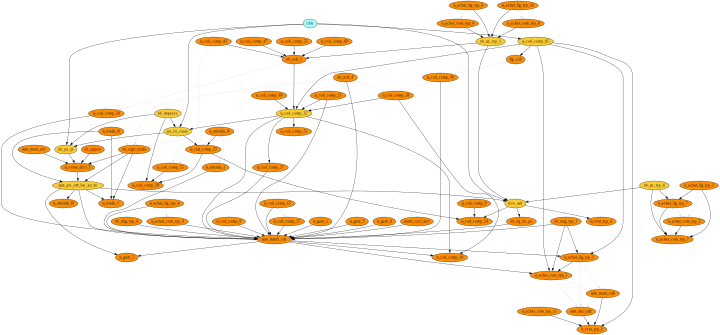

In [25]:
gnb.showGraph(exp.nestedMarkovBlankets(bn_miic, 'cible',2), size='10!')

## Other ML models

In [26]:
df_label = df.copy()

for col in df_label.columns:
    if df_label[col].dtype == object:
        lb_make = preprocessing.LabelEncoder()
        df_label[col] = lb_make.fit_transform(df_label[col])

In [27]:

names = ["Logistic Regression", "Decision Tree", "Random Forest", 
         "Neural Net", "AdaBoost", "Naive Bayes", "QDA", "XgBoost", "LGBM"]

classifiers = [LogisticRegression(max_iter=1000), DecisionTreeClassifier(), RandomForestClassifier(),
               MLPClassifier(), AdaBoostClassifier(), GaussianNB(), QuadraticDiscriminantAnalysis(), 
               XGBClassifier(), lightgbm.LGBMClassifier()]
    
res = []


for cla in range(len(classifiers)) :
    print(names[cla])

    X_train, X_test, Y_train, Y_test = train_test_split(df_label.drop('cible', axis=1), df_label['cible'],
                                                        shuffle=True, test_size=0.25)                
    cl = classifiers[cla]

    try : 
        cl.fit(X_train, Y_train)

    except  Exception as error:
        print("An exception occurred:", type(error).__name__, "–", error)
        break 

    y_test_pred = cl.predict(X_test)

    res.append(fbeta_score(Y_test, y_test_pred, beta=2))

    print(f"F-score : {f1_score(Y_test, y_test_pred):.2f}")
    print(f"F2-score : {fbeta_score(Y_test, y_test_pred, beta=2):.2f}")
    print(f"Precision : {precision_recall_fscore_support(Y_test, y_test_pred)[0][1]:.2f}")
    print(f"Recall : {precision_recall_fscore_support(Y_test, y_test_pred)[1][1]:.2f}")
    print(f"Accuracy : {accuracy_score(Y_test, y_test_pred):.2f}")
    print("Confusion Matrix :")
    print(confusion_matrix(Y_test, y_test_pred))
    print(f"Score Perso : {score_perso(Y_test, y_test_pred):.2f}")
    print('\n')

    if names[cla] == "XgBoost" :
        y_score = cl.predict_proba(X_test)
        fpr_XGB, tpr_XGB, _ = roc_curve(Y_test, [point[1] for point in y_score])
        
    if names[cla] == "LGBM" :
        y_score = cl.predict_proba(X_test)
        fpr_LGBM, tpr_LGBM, _ = roc_curve(Y_test, [point[1] for point in y_score])


Logistic Regression


/opt/homebrew/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


F-score : 0.38
F2-score : 0.30
Precision : 0.67
Recall : 0.27
Accuracy : 0.88
Confusion Matrix :
[[5605  126]
 [ 699  256]]
Score Perso : 0.06


Decision Tree
F-score : 0.44
F2-score : 0.45
Precision : 0.41
Recall : 0.47
Accuracy : 0.83
Confusion Matrix :
[[5151  614]
 [ 492  429]]
Score Perso : 0.16


Random Forest
F-score : 0.43
F2-score : 0.34
Precision : 0.74
Recall : 0.30
Accuracy : 0.88
Confusion Matrix :
[[5589  107]
 [ 691  299]]
Score Perso : 0.06


Neural Net


/opt/homebrew/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


F-score : 0.46
F2-score : 0.45
Precision : 0.47
Recall : 0.45
Accuracy : 0.85
Confusion Matrix :
[[5226  491]
 [ 534  435]]
Score Perso : 0.14


AdaBoost
F-score : 0.40
F2-score : 0.32
Precision : 0.66
Recall : 0.29
Accuracy : 0.88
Confusion Matrix :
[[5600  138]
 [ 676  272]]
Score Perso : 0.06


Naive Bayes
F-score : 0.28
F2-score : 0.47
Precision : 0.17
Recall : 0.85
Accuracy : 0.38
Confusion Matrix :
[[1703 4031]
 [ 141  811]]
Score Perso : 0.72


QDA


/opt/homebrew/lib/python3.11/site-packages/sklearn/discriminant_analysis.py:926: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


F-score : 0.24
F2-score : 0.45
Precision : 0.14
Recall : 0.98
Accuracy : 0.16
Confusion Matrix :
[[ 161 5600]
 [  15  910]]
Score Perso : 0.97


XgBoost
F-score : 0.49
F2-score : 0.41
Precision : 0.69
Recall : 0.37
Accuracy : 0.88
Confusion Matrix :
[[5539  162]
 [ 617  368]]
Score Perso : 0.08


LGBM
[LightGBM] [Info] Number of positive: 2925, number of negative: 17130
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.012689 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 422
[LightGBM] [Info] Number of data points in the train set: 20055, number of used features: 154
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.145849 -> initscore=-1.767537
[LightGBM] [Info] Start training from score -1.767537
F-score : 0.50
F2-score : 0.42
Precision : 0.77
Recall : 0.38
Accuracy : 0.90
Confusion Matrix :
[[5669  105]
 [ 570  342]]
Score Perso :

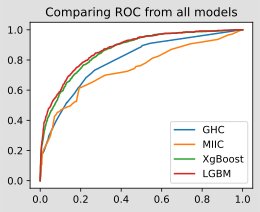

In [28]:

points= getROCpoints(cl_GHC.bn, df_test, 'cible', 1)
x=[point[0] for point in points]
y=[point[1] for point in points]
plt.plot(x,y,label="GHC")

points= getROCpoints(cl_MIIC.bn, df_test, 'cible', 1)
x1=[point[0] for point in points]
y1=[point[1] for point in points]
plt.plot(x1,y1,label="MIIC")

x2=fpr_XGB
y2=tpr_XGB
plt.plot(x2,y2,label="XgBoost")

x3=fpr_LGBM
y3=tpr_LGBM
plt.plot(x3,y3,label="LGBM")

plt.title("Comparing ROC from all models")
plt.legend()

## Shap Values

In [29]:
def compute_shap_bn(df, mb, train_sample=0.1, target='cible'):

    df_mb = df[list(mb.names())]
    print(mb.names())

    gumshap = exp.ShapValues(mb, target)
    train = df_mb.sample(frac=train_sample)
    t_start = time.time()
    plt.plot()
    marginal = gumshap.marginal(train, plot=True, plot_importance=True, percentage=False)
    plt.figure()
    print(f'Run Time : {time.time() - t_start} sec')


    return gumshap.results

In [ ]:
res = compute_shap_bn(df, cl_MIIC.MarkovBlanket)

{'sum_prx_offr_bse_arr_ttc', 'is_cod_comp_32', 'nb_pa_rjt', 'nb_ssc_typ_1', 'nb_impayes', 'is_cod_comp_85', 'nb_ssc_typ_4', 'pa_en_cours', 'new_sub', 'cible'}


/opt/homebrew/lib/python3.11/site-packages/pyAgrum/lib/explain.py:601: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  v.loc[i, f'{col_arr_name}'] = np.mean(self._logit(self._predict_marginal(intervention, ie)))
/opt/homebrew/lib/python3.11/site-packages/pyAgrum/lib/explain.py:601: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  v.loc[i, f'{col_arr_name}'] = np.mean(self._logit(self._predict_marginal(intervention, ie)))
/opt/homebrew/lib/python3.11/site-packages/pyAgrum/lib/explain.py:601: PerformanceWarning: DataFrame is highly fra

/opt/homebrew/lib/python3.11/site-packages/pyAgrum/lib/explain.py:601: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  v.loc[i, f'{col_arr_name}'] = np.mean(self._logit(self._predict_marginal(intervention, ie)))
/opt/homebrew/lib/python3.11/site-packages/pyAgrum/lib/explain.py:601: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  v.loc[i, f'{col_arr_name}'] = np.mean(self._logit(self._predict_marginal(intervention, ie)))
/opt/homebrew/lib/python3.11/site-packages/pyAgrum/lib/explain.py:601: PerformanceWarning: DataFrame is highly fra

/opt/homebrew/lib/python3.11/site-packages/pyAgrum/lib/explain.py:601: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  v.loc[i, f'{col_arr_name}'] = np.mean(self._logit(self._predict_marginal(intervention, ie)))
/opt/homebrew/lib/python3.11/site-packages/pyAgrum/lib/explain.py:601: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  v.loc[i, f'{col_arr_name}'] = np.mean(self._logit(self._predict_marginal(intervention, ie)))
/opt/homebrew/lib/python3.11/site-packages/pyAgrum/lib/explain.py:601: PerformanceWarning: DataFrame is highly fra

/opt/homebrew/lib/python3.11/site-packages/pyAgrum/lib/explain.py:601: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  v.loc[i, f'{col_arr_name}'] = np.mean(self._logit(self._predict_marginal(intervention, ie)))
/opt/homebrew/lib/python3.11/site-packages/pyAgrum/lib/explain.py:601: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  v.loc[i, f'{col_arr_name}'] = np.mean(self._logit(self._predict_marginal(intervention, ie)))
/opt/homebrew/lib/python3.11/site-packages/pyAgrum/lib/explain.py:601: PerformanceWarning: DataFrame is highly fra

/opt/homebrew/lib/python3.11/site-packages/pyAgrum/lib/explain.py:601: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  v.loc[i, f'{col_arr_name}'] = np.mean(self._logit(self._predict_marginal(intervention, ie)))
/opt/homebrew/lib/python3.11/site-packages/pyAgrum/lib/explain.py:601: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  v.loc[i, f'{col_arr_name}'] = np.mean(self._logit(self._predict_marginal(intervention, ie)))
/opt/homebrew/lib/python3.11/site-packages/pyAgrum/lib/explain.py:601: PerformanceWarning: DataFrame is highly fra

/opt/homebrew/lib/python3.11/site-packages/pyAgrum/lib/explain.py:601: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  v.loc[i, f'{col_arr_name}'] = np.mean(self._logit(self._predict_marginal(intervention, ie)))
/opt/homebrew/lib/python3.11/site-packages/pyAgrum/lib/explain.py:601: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  v.loc[i, f'{col_arr_name}'] = np.mean(self._logit(self._predict_marginal(intervention, ie)))
/opt/homebrew/lib/python3.11/site-packages/pyAgrum/lib/explain.py:601: PerformanceWarning: DataFrame is highly fra

/opt/homebrew/lib/python3.11/site-packages/pyAgrum/lib/explain.py:601: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  v.loc[i, f'{col_arr_name}'] = np.mean(self._logit(self._predict_marginal(intervention, ie)))
/opt/homebrew/lib/python3.11/site-packages/pyAgrum/lib/explain.py:601: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  v.loc[i, f'{col_arr_name}'] = np.mean(self._logit(self._predict_marginal(intervention, ie)))
/opt/homebrew/lib/python3.11/site-packages/pyAgrum/lib/explain.py:601: PerformanceWarning: DataFrame is highly fra

/opt/homebrew/lib/python3.11/site-packages/pyAgrum/lib/explain.py:601: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  v.loc[i, f'{col_arr_name}'] = np.mean(self._logit(self._predict_marginal(intervention, ie)))
/opt/homebrew/lib/python3.11/site-packages/pyAgrum/lib/explain.py:601: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  v.loc[i, f'{col_arr_name}'] = np.mean(self._logit(self._predict_marginal(intervention, ie)))
/opt/homebrew/lib/python3.11/site-packages/pyAgrum/lib/explain.py:601: PerformanceWarning: DataFrame is highly fra

/opt/homebrew/lib/python3.11/site-packages/pyAgrum/lib/explain.py:601: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  v.loc[i, f'{col_arr_name}'] = np.mean(self._logit(self._predict_marginal(intervention, ie)))
/opt/homebrew/lib/python3.11/site-packages/pyAgrum/lib/explain.py:601: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  v.loc[i, f'{col_arr_name}'] = np.mean(self._logit(self._predict_marginal(intervention, ie)))
/opt/homebrew/lib/python3.11/site-packages/pyAgrum/lib/explain.py:601: PerformanceWarning: DataFrame is highly fra

/opt/homebrew/lib/python3.11/site-packages/pyAgrum/lib/explain.py:601: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  v.loc[i, f'{col_arr_name}'] = np.mean(self._logit(self._predict_marginal(intervention, ie)))
/opt/homebrew/lib/python3.11/site-packages/pyAgrum/lib/explain.py:601: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  v.loc[i, f'{col_arr_name}'] = np.mean(self._logit(self._predict_marginal(intervention, ie)))
/opt/homebrew/lib/python3.11/site-packages/pyAgrum/lib/explain.py:601: PerformanceWarning: DataFrame is highly fra

/opt/homebrew/lib/python3.11/site-packages/pyAgrum/lib/explain.py:601: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  v.loc[i, f'{col_arr_name}'] = np.mean(self._logit(self._predict_marginal(intervention, ie)))
/opt/homebrew/lib/python3.11/site-packages/pyAgrum/lib/explain.py:601: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  v.loc[i, f'{col_arr_name}'] = np.mean(self._logit(self._predict_marginal(intervention, ie)))
/opt/homebrew/lib/python3.11/site-packages/pyAgrum/lib/explain.py:601: PerformanceWarning: DataFrame is highly fra

/opt/homebrew/lib/python3.11/site-packages/pyAgrum/lib/explain.py:601: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  v.loc[i, f'{col_arr_name}'] = np.mean(self._logit(self._predict_marginal(intervention, ie)))
/opt/homebrew/lib/python3.11/site-packages/pyAgrum/lib/explain.py:601: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  v.loc[i, f'{col_arr_name}'] = np.mean(self._logit(self._predict_marginal(intervention, ie)))
/opt/homebrew/lib/python3.11/site-packages/pyAgrum/lib/explain.py:601: PerformanceWarning: DataFrame is highly fra

/opt/homebrew/lib/python3.11/site-packages/pyAgrum/lib/explain.py:601: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  v.loc[i, f'{col_arr_name}'] = np.mean(self._logit(self._predict_marginal(intervention, ie)))
/opt/homebrew/lib/python3.11/site-packages/pyAgrum/lib/explain.py:601: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  v.loc[i, f'{col_arr_name}'] = np.mean(self._logit(self._predict_marginal(intervention, ie)))
/opt/homebrew/lib/python3.11/site-packages/pyAgrum/lib/explain.py:601: PerformanceWarning: DataFrame is highly fra

/opt/homebrew/lib/python3.11/site-packages/pyAgrum/lib/explain.py:601: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  v.loc[i, f'{col_arr_name}'] = np.mean(self._logit(self._predict_marginal(intervention, ie)))
/opt/homebrew/lib/python3.11/site-packages/pyAgrum/lib/explain.py:601: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  v.loc[i, f'{col_arr_name}'] = np.mean(self._logit(self._predict_marginal(intervention, ie)))
/opt/homebrew/lib/python3.11/site-packages/pyAgrum/lib/explain.py:601: PerformanceWarning: DataFrame is highly fra

/opt/homebrew/lib/python3.11/site-packages/pyAgrum/lib/explain.py:601: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  v.loc[i, f'{col_arr_name}'] = np.mean(self._logit(self._predict_marginal(intervention, ie)))
/opt/homebrew/lib/python3.11/site-packages/pyAgrum/lib/explain.py:601: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  v.loc[i, f'{col_arr_name}'] = np.mean(self._logit(self._predict_marginal(intervention, ie)))
/opt/homebrew/lib/python3.11/site-packages/pyAgrum/lib/explain.py:601: PerformanceWarning: DataFrame is highly fra

/opt/homebrew/lib/python3.11/site-packages/pyAgrum/lib/explain.py:601: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  v.loc[i, f'{col_arr_name}'] = np.mean(self._logit(self._predict_marginal(intervention, ie)))
/opt/homebrew/lib/python3.11/site-packages/pyAgrum/lib/explain.py:601: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  v.loc[i, f'{col_arr_name}'] = np.mean(self._logit(self._predict_marginal(intervention, ie)))
/opt/homebrew/lib/python3.11/site-packages/pyAgrum/lib/explain.py:601: PerformanceWarning: DataFrame is highly fra

/opt/homebrew/lib/python3.11/site-packages/pyAgrum/lib/explain.py:601: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  v.loc[i, f'{col_arr_name}'] = np.mean(self._logit(self._predict_marginal(intervention, ie)))
/opt/homebrew/lib/python3.11/site-packages/pyAgrum/lib/explain.py:601: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  v.loc[i, f'{col_arr_name}'] = np.mean(self._logit(self._predict_marginal(intervention, ie)))
/opt/homebrew/lib/python3.11/site-packages/pyAgrum/lib/explain.py:601: PerformanceWarning: DataFrame is highly fra

/opt/homebrew/lib/python3.11/site-packages/pyAgrum/lib/explain.py:601: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  v.loc[i, f'{col_arr_name}'] = np.mean(self._logit(self._predict_marginal(intervention, ie)))
/opt/homebrew/lib/python3.11/site-packages/pyAgrum/lib/explain.py:601: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  v.loc[i, f'{col_arr_name}'] = np.mean(self._logit(self._predict_marginal(intervention, ie)))
/opt/homebrew/lib/python3.11/site-packages/pyAgrum/lib/explain.py:601: PerformanceWarning: DataFrame is highly fra